In [1]:
pip install librosa pretty_midi numpy matplotlib tqdm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import librosa
import numpy as np
import pretty_midi
from tqdm import tqdm

# ✅ Define Paths
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0"
OUTPUT_DIR = os.path.join(DATASET_PATH, "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ✅ Delete old processed files
for f in os.listdir(OUTPUT_DIR):
    os.remove(os.path.join(OUTPUT_DIR, f))
print("🗑️ Deleted old processed files!")

# ✅ Audio Processing Parameters (From Paper)
SAMPLE_RATE = 16000
N_MELS = 229
HOP_LENGTH = 512
N_FFT = 2048
SEGMENT_DURATION = 20  # 20-second segments
SEGMENT_SAMPLES = SAMPLE_RATE * SEGMENT_DURATION  # 320,000 samples per segment
MEL_SHAPE = (480, 229)

# ✅ Function to Convert Audio to Mel Spectrogram
def process_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
    mel_segments = []

    for i in range(0, len(y), SEGMENT_SAMPLES):
        segment = y[i : i + SEGMENT_SAMPLES]

        if len(segment) < SEGMENT_SAMPLES:
            break

        mel_spec = librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # ✅ Truncate to match 480 time frames
        mel_spec_fixed = mel_spec_db.T[:480, :]
        mel_segments.append(mel_spec_fixed)

    return mel_segments

# ✅ Function to Convert MIDI to Binary Piano Roll
def process_midi(midi_path, num_segments):
    midi = pretty_midi.PrettyMIDI(midi_path)
    piano_roll_full = midi.get_piano_roll(fs=SAMPLE_RATE / HOP_LENGTH).T  # (time_steps, 128)
    piano_roll_full = piano_roll_full[:, 21:109]  # Convert 128 → 88 notes
    piano_roll_full = np.where(piano_roll_full > 0, 1, 0)  # Convert to binary (0/1)

    piano_roll_segments = []

    for i in range(num_segments):
        start_idx = i * MEL_SHAPE[0]
        end_idx = start_idx + MEL_SHAPE[0]
        segment = piano_roll_full[start_idx:end_idx]

        if segment.shape[0] < MEL_SHAPE[0]:  # Pad if shorter
            pad_width = MEL_SHAPE[0] - segment.shape[0]
            segment = np.pad(segment, ((0, pad_width), (0, 0)), mode='constant')

        piano_roll_segments.append(segment)

    return piano_roll_segments

# ✅ Process All Files
mel_spectrograms, piano_rolls = [], []
file_pairs = []

for root, _, files in os.walk(DATASET_PATH):
    audio_files = sorted([f for f in files if f.endswith(".wav")])
    midi_files = sorted([f for f in files if f.endswith(".midi") or f.endswith(".mid")])

    for audio_file, midi_file in zip(audio_files, midi_files):
        audio_path = os.path.join(root, audio_file)
        midi_path = os.path.join(root, midi_file)
        file_pairs.append((audio_path, midi_path))

# ✅ Processing with Progress Bar
for audio_path, midi_path in tqdm(file_pairs, desc="Processing MAESTRO Dataset", total=len(file_pairs)):
    try:
        mel_segments = process_audio(audio_path)
        num_segments = len(mel_segments)

        piano_roll_segments = process_midi(midi_path, num_segments)

        # ✅ Ensure Number of Segments Match
        min_segments = min(len(mel_segments), len(piano_roll_segments))
        mel_segments = mel_segments[:min_segments]
        piano_roll_segments = piano_roll_segments[:min_segments]

        # ✅ Save Each Segment
        for idx, (mel_spec, piano_roll) in enumerate(zip(mel_segments, piano_roll_segments)):
            mel_filename = f"{os.path.basename(audio_path).replace('.wav', f'_seg{idx}.mel.npy')}"
            roll_filename = f"{os.path.basename(midi_path).replace('.mid', f'_seg{idx}.roll.npy').replace('.midi', f'_seg{idx}.roll.npy')}"

            np.save(os.path.join(OUTPUT_DIR, mel_filename), mel_spec)
            np.save(os.path.join(OUTPUT_DIR, roll_filename), piano_roll)

            mel_spectrograms.append(mel_spec)
            piano_rolls.append(piano_roll)

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

# ✅ Save Final Dataset
np.save(os.path.join(OUTPUT_DIR, "mel_spectrograms.npy"), np.array(mel_spectrograms, dtype=np.float32))
np.save(os.path.join(OUTPUT_DIR, "piano_rolls.npy"), np.array(piano_rolls, dtype=np.float32))

print(f"✅ Total Mel Spectrograms: {len(mel_spectrograms)}")
print(f"✅ Total Piano Rolls: {len(piano_rolls)}")
print("✅ Preprocessing Complete! Mel Spectrograms & Piano Rolls Saved.")


🗑️ Deleted old processed files!


Processing MAESTRO Dataset: 100%|█████████| 1276/1276 [1:25:59<00:00,  4.04s/it]


✅ Total Mel Spectrograms: 35232
✅ Total Piano Rolls: 35232
✅ Preprocessing Complete! Mel Spectrograms & Piano Rolls Saved.


In [6]:
import numpy as np

DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"

Y_train = np.load(f"{DATASET_PATH}/Y_train.npy")  # (28185, 480, 88)

total_elements = np.prod(Y_train.shape)
total_ones = np.sum(Y_train)
percentage_ones = (total_ones / total_elements) * 100

print(f"✅ Total Elements: {total_elements}")
print(f"✅ Total Ones (Notes): {total_ones}")
print(f"🔹 Percentage of Notes (1s): {percentage_ones:.4f}%")


✅ Total Elements: 1190534400
✅ Total Ones (Notes): 64097040.0
🔹 Percentage of Notes (1s): 5.3839%


In [9]:
import numpy as np

# ✅ Load Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
Y_train = np.load(f"{DATASET_PATH}/Y_train.npy")
Y_val = np.load(f"{DATASET_PATH}/Y_val.npy")
Y_test = np.load(f"{DATASET_PATH}/Y_test.npy")

# ✅ Combine All
Y_total = np.concatenate([Y_train, Y_val, Y_test], axis=0)

# ✅ Compute Correct Total Frames
total_frames = Y_total.shape[0] * Y_total.shape[1] * Y_total.shape[2]  # (samples × 480 × 88)
note_frames = np.sum(Y_total)  # Count of 1s
silent_frames = total_frames - note_frames  # Correct way to compute silent frames

# ✅ Print Results
print(f"🎵 Corrected Total Frames: {total_frames}")
print(f"🎵 Corrected Total Note Frames: {note_frames} ({(note_frames / total_frames) * 100:.2f}%)")
print(f"🔇 Corrected Total Silent Frames: {silent_frames} ({(silent_frames / total_frames) * 100:.2f}%)")


🎵 Corrected Total Frames: 1488199680
🎵 Corrected Total Note Frames: 80045016.0 (5.38%)
🔇 Corrected Total Silent Frames: 1408154664.0 (94.62%)


In [1]:
import numpy as np
import os

# ✅ Define Paths
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"

# ✅ Load Preprocessed Data
mel_spectrograms = np.load(os.path.join(DATASET_PATH, "mel_spectrograms.npy"))
piano_rolls = np.load(os.path.join(DATASET_PATH, "piano_rolls.npy"))

# ✅ Check Shapes
print(f"🔹 Mel Spectrogram Shape: {mel_spectrograms.shape}")  # Expected: (35232, 480, 229)
print(f"🔹 Piano Roll Shape: {piano_rolls.shape}")  # Expected: (35232, 480, 88)

# ✅ Ensure Min & Max Values Make Sense
print(f"🔹 Mel Spectrogram Min: {mel_spectrograms.min()}, Max: {mel_spectrograms.max()}")
print(f"🔹 Piano Roll Min: {piano_rolls.min()}, Max: {piano_rolls.max()}")

# ✅ Check for NaN or Inf values
print(f"🔹 Any NaN in Mel Spectrograms? {np.isnan(mel_spectrograms).any()}")
print(f"🔹 Any Inf in Mel Spectrograms? {np.isinf(mel_spectrograms).any()}")
print(f"🔹 Any NaN in Piano Rolls? {np.isnan(piano_rolls).any()}")
print(f"🔹 Any Inf in Piano Rolls? {np.isinf(piano_rolls).any()}")

# ✅ Check Unique Values in Piano Roll (Should be Binary: 0 or 1)
print(f"🔹 Unique values in Piano Rolls: {np.unique(piano_rolls)}")


🔹 Mel Spectrogram Shape: (35232, 480, 229)
🔹 Piano Roll Shape: (35232, 480, 88)
🔹 Mel Spectrogram Min: -80.0, Max: 3.814697265625e-06
🔹 Piano Roll Min: 0.0, Max: 1.0
🔹 Any NaN in Mel Spectrograms? False
🔹 Any Inf in Mel Spectrograms? False
🔹 Any NaN in Piano Rolls? False
🔹 Any Inf in Piano Rolls? False
🔹 Unique values in Piano Rolls: [0. 1.]


In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

# ✅ Define Paths
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"

# ✅ Load Preprocessed Data
X = np.load(os.path.join(DATASET_PATH, "mel_spectrograms.npy"))  # (35232, 480, 229)
Y = np.load(os.path.join(DATASET_PATH, "piano_rolls.npy"))       # (35232, 480, 88)  # ✅ Ensure 88 Notes

print(f"🔹 Before Fixing: X Shape: {X.shape}, Y Shape: {Y.shape}")

# ✅ Ensure Y has Correct Shape (88 Notes)
assert Y.shape[2] == 88, f"❌ ERROR: Y should have 88 notes, but found {Y.shape[2]}"

# ✅ Split Dataset (80% Train, 10% Val, 10% Test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"✅ Dataset Split Complete!")
print(f"🔹 Train: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"🔹 Validation: X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"🔹 Test: X_test: {X_test.shape}, Y_test: {Y_test.shape}")

# ✅ Reshape for CNN (Add Channel Dimension) - ONLY FOR X
X_train = X_train[..., np.newaxis]  # (28185, 480, 229, 1)
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# ❌ DO NOT RESHAPE Y (It's Already Binary)

# ✅ Normalize X Data (Min-Max Scaling)
X_min = X_train.min()
X_max = X_train.max()
X_train = (X_train - X_min) / (X_max - X_min)
X_val = (X_val - X_min) / (X_max - X_min)
X_test = (X_test - X_min) / (X_max - X_min)

print(f"✅ After Reshaping & Normalization:")
print(f"🔹 X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"🔹 X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"🔹 X_test: {X_test.shape}, Y_test: {Y_test.shape}")

# ✅ Save Final Fixed Data
np.save(os.path.join(DATASET_PATH, "X_train.npy"), X_train)
np.save(os.path.join(DATASET_PATH, "X_val.npy"), X_val)
np.save(os.path.join(DATASET_PATH, "X_test.npy"), X_test)

np.save(os.path.join(DATASET_PATH, "Y_train.npy"), Y_train)  # No extra channel dim
np.save(os.path.join(DATASET_PATH, "Y_val.npy"), Y_val)
np.save(os.path.join(DATASET_PATH, "Y_test.npy"), Y_test)

print("✅ Data Shapes Fixed, Split, Reshaped, Normalized, and Saved! 🎉")


🔹 Before Fixing: X Shape: (35232, 480, 229), Y Shape: (35232, 480, 88)
✅ Dataset Split Complete!
🔹 Train: X_train: (28185, 480, 229), Y_train: (28185, 480, 88)
🔹 Validation: X_val: (3523, 480, 229), Y_val: (3523, 480, 88)
🔹 Test: X_test: (3524, 480, 229), Y_test: (3524, 480, 88)
✅ After Reshaping & Normalization:
🔹 X_train: (28185, 480, 229, 1), Y_train: (28185, 480, 88)
🔹 X_val: (3523, 480, 229, 1), Y_val: (3523, 480, 88)
🔹 X_test: (3524, 480, 229, 1), Y_test: (3524, 480, 88)
✅ Data Shapes Fixed, Split, Reshaped, Normalized, and Saved! 🎉


In [3]:
import numpy as np

# ✅ Load Preprocessed Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
Y_train = np.load(f"{DATASET_PATH}/Y_train.npy")  # (28185, 480, 88)
Y_val = np.load(f"{DATASET_PATH}/Y_val.npy")      # (3523, 480, 88)
Y_test = np.load(f"{DATASET_PATH}/Y_test.npy")    # (3524, 480, 88)

# ✅ Compute Class Distribution
total_ones = np.sum(Y_train) + np.sum(Y_val) + np.sum(Y_test)
total_elements = Y_train.size + Y_val.size + Y_test.size
percentage_ones = (total_ones / total_elements) * 100

print(f"✅ Total Elements: {total_elements}")
print(f"✅ Total Ones (Notes): {total_ones}")
print(f"🔹 Percentage of Notes (1s): {percentage_ones:.4f}%")

# ✅ Check Number of Empty Frames (Frames where all notes are 0)
def count_empty_frames(Y):
    return np.sum(np.all(Y == 0, axis=(1, 2)))  # Count frames with all zeros

train_empty_frames = count_empty_frames(Y_train)
val_empty_frames = count_empty_frames(Y_val)
test_empty_frames = count_empty_frames(Y_test)

print(f"🛑 Empty Frames in Training Data: {train_empty_frames}")
print(f"🛑 Empty Frames in Validation Data: {val_empty_frames}")
print(f"🛑 Empty Frames in Test Data: {test_empty_frames}")


✅ Total Elements: 1488199680
✅ Total Ones (Notes): 80045312.0
🔹 Percentage of Notes (1s): 5.3787%
🛑 Empty Frames in Training Data: 17
🛑 Empty Frames in Validation Data: 0
🛑 Empty Frames in Test Data: 1


In [2]:
import os
import numpy as np

# ✅ Define Dataset Path
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"

# ✅ Load Preprocessed Data (with full path)
X_train = np.load(os.path.join(DATASET_PATH, "X_train.npy"))  # (28185, 480, 229, 1)
Y_train = np.load(os.path.join(DATASET_PATH, "Y_train.npy"))  # (28185, 480, 128, 1)

X_val = np.load(os.path.join(DATASET_PATH, "X_val.npy"))  # (3523, 480, 229, 1)
Y_val = np.load(os.path.join(DATASET_PATH, "Y_val.npy"))  # (3523, 480, 128, 1)


In [10]:
import numpy as np
import os

# ✅ Load Preprocessed Labels (Y_train) - Shape: (28185, 480, 88)
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
Y_train = np.load(os.path.join(DATASET_PATH, "Y_train.npy"))

# ✅ Step 1: Compute Co-occurrence Matrix (M)
num_notes = 88  # Fixed number of piano notes (A0 to C8)
M = np.zeros((num_notes, num_notes), dtype=np.float32)

# Iterate over all training frames
for song in Y_train:
    for frame in song:
        active_notes = np.where(frame == 1)[0]  # Get active note indices
        for i in range(len(active_notes)):
            for j in range(i, len(active_notes)):  # Symmetric count
                M[active_notes[i], active_notes[j]] += 1
                if i != j:
                    M[active_notes[j], active_notes[i]] += 1  # Ensure symmetry

# ✅ Step 2: Normalize to Conditional Probability Matrix (P)
note_occurrences = np.sum(M, axis=1, keepdims=True)  # Sum over rows
P = np.divide(M, note_occurrences, where=note_occurrences != 0)  # Avoid division by zero

# ✅ Step 3: Dynamically Choose Threshold (τ)
percentile = 90  # Keep the top 10% of strongest connections
tau = np.percentile(P[P > 0], percentile)  # Get the 90th percentile value
print(f"✅ Dynamic Threshold (τ): {tau:.5f}")

# ✅ Step 4: Construct Binary Adjacency Matrix (A)
A = (P >= tau).astype(np.float32)

# ✅ Step 5: Apply Soft Normalization Instead of Hard Binarization
A = A * P / np.max(P)  # Scale A to avoid hard 0s/1s

# ✅ Save the Adjacency Matrix
np.save(os.path.join(DATASET_PATH, "adjacency_matrix.npy"), A)
print("✅ Adjacency Matrix Construction Complete!")


✅ Dynamic Threshold (τ): 0.02491
✅ Adjacency Matrix Construction Complete!


In [11]:
import numpy as np
import os

# ✅ Load Adjacency Matrix
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
A = np.load(os.path.join(DATASET_PATH, "adjacency_matrix.npy"))

# ✅ Check Density (How many connections exist?)
density = np.sum(A > 0) / (A.shape[0] * A.shape[1])
print(f"🔍 Adjacency Matrix Density: {density:.4f}")

# ✅ Check Min/Max Values
print(f"🔹 Min Value: {np.min(A)}")
print(f"🔹 Max Value: {np.max(A)}")

# ✅ Example Note Connections (Row 60: Middle C - MIDI 60)
print(f"🎼 Connections for MIDI Note 60 (C4): {np.where(A[60] > 0)[0]}")

# ✅ Check for Isolated Nodes (Any notes completely disconnected?)
isolated_notes = np.where(np.sum(A, axis=1) == 0)[0]
print(f"🛑 Isolated Notes (No connections): {isolated_notes}")


🔍 Adjacency Matrix Density: 0.0987
🔹 Min Value: 0.0
🔹 Max Value: 1.0
🎼 Connections for MIDI Note 60 (C4): [36 48 55 57 60]
🛑 Isolated Notes (No connections): []


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, 
                                     Reshape, Dropout, TimeDistributed, Dot)
import numpy as np

# ✅ Load Preprocessed Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
X_train = np.load(f"{DATASET_PATH}/X_train.npy")  # (28185, 480, 229, 1)
Y_train = np.load(f"{DATASET_PATH}/Y_train.npy")  # (28185, 480, 88)
X_val = np.load(f"{DATASET_PATH}/X_val.npy")      # (3523, 480, 229, 1)
Y_val = np.load(f"{DATASET_PATH}/Y_val.npy")      # (3523, 480, 88)
A_matrix = np.load(f"{DATASET_PATH}/adjacency_matrix.npy")  # (88, 88)

# ✅ Normalize Adjacency Matrix
A_matrix = tf.convert_to_tensor(A_matrix, dtype=tf.float32)

# ✅ Feature Learning Network (CNN + LSTM)
def build_cnn_lstm():
    input_layer = Input(shape=(480, 229, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Reshape((480, -1))(x)  # Flatten only frequency axis

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)

    output = Dense(768, activation='relu')(x)  # Output shape: (480, 768)

    return Model(input_layer, output, name="CNN_LSTM")

# ✅ GCN for Label Learning
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation="relu"):
        super(GraphConvolution, self).__init__()
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[0][-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.output_dim),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        X, A = inputs
        output = tf.matmul(A, X)  # A * X
        output = tf.matmul(output, self.kernel)  # (A * X) * W
        return self.activation(output)

# ✅ Build GCN Model
def build_gcn():
    X_input = Input(shape=(88, 88))  # One-hot encoded input
    A_input = Input(shape=(88, 88))  # Adjacency matrix

    x = GraphConvolution(256)([X_input, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(128)([x, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(768, activation="linear")([x, A_input])  # Output shape: (88, 768)

    return Model([X_input, A_input], x, name="GCN")

# ✅ Integrate CNN+LSTM & GCN
cnn_lstm_model = build_cnn_lstm()
gcn_model = build_gcn()

# CNN+LSTM Output (480, 768)
X_audio = cnn_lstm_model.output  # (batch_size, 480, 768)

# GCN Output (88, 768)
X_graph = gcn_model([tf.expand_dims(tf.eye(88), axis=0), tf.expand_dims(A_matrix, axis=0)])
# One-hot encoding & adjacency matrix

# ✅ Compute Dot Product
final_output = Dot(axes=-1)([X_audio, X_graph])  # (batch_size, 480, 88)
final_output = tf.keras.activations.sigmoid(final_output)  # Apply sigmoid

# ✅ Define Final Model
full_model = Model(cnn_lstm_model.input, final_output, name="Full_CNN_LSTM_GCN")

# ✅ Compile Model (Binary Cross-Entropy for Multi-Label Classification)
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.006),
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# ✅ Learning Rate Scheduler (Paper used decay every 10,000 steps)
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.98  # Decay factor
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# ✅ Define Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("best_full_model.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = full_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_callback]
)

# ✅ Save Final Model
full_model.save("final_cnn_lstm_gcn_model.h5")
print("✅ Training Complete! Best model saved as 'best_full_model.h5'")

Epoch 1/30
 553/1762 ━━━━━━━━━━━━━━━━━━━━ 8:38 429ms/step - accuracy: 0.0104 - loss: 0.3028 - precision: 0.0471 - recall: 0.0153

KeyboardInterrupt: 

In [7]:
import numpy as np

# ✅ Load Processed Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
Y_train = np.load(f"{DATASET_PATH}/Y_train.npy")  # (28185, 480, 88)

# ✅ Count Active Notes per Frame
active_notes_per_frame = np.sum(Y_train, axis=-1)  # Sum across 88 notes

# ✅ Print Statistics
print(f"🎵 Min Notes Per Frame: {np.min(active_notes_per_frame)}")
print(f"🎵 Max Notes Per Frame: {np.max(active_notes_per_frame)}")
print(f"🎵 Avg Notes Per Frame: {np.mean(active_notes_per_frame):.2f}")
print(f"🎵 Median Notes Per Frame: {np.median(active_notes_per_frame)}")


🎵 Min Notes Per Frame: 0.0
🎵 Max Notes Per Frame: 58.0
🎵 Avg Notes Per Frame: 4.74
🎵 Median Notes Per Frame: 4.0


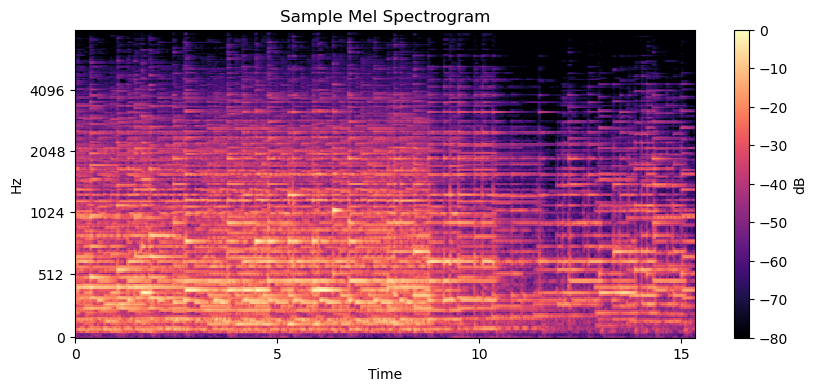

In [3]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load a sample mel spectrogram
mel_sample = np.load("/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--4_seg14.mel.npy")

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_sample.T, sr=16000, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.title("Sample Mel Spectrogram")
plt.show()


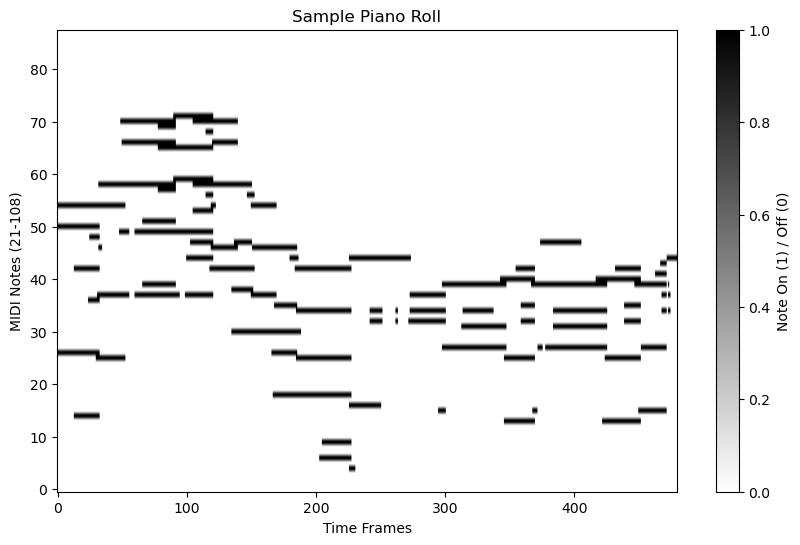

In [5]:
import matplotlib.pyplot as plt

# Load a sample piano roll
piano_roll_sample = np.load("/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--4_seg9.roll.npyi.npy")

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(piano_roll_sample.T, aspect='auto', cmap='gray_r', origin='lower')
plt.xlabel("Time Frames")
plt.ylabel("MIDI Notes (21-108)")
plt.title("Sample Piano Roll")
plt.colorbar(label="Note On (1) / Off (0)")
plt.show()


In [6]:
import numpy as np

# Load full dataset
Y_train = np.load("/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed/Y_train.npy")

# Count total frames
total_frames = Y_train.shape[0] * Y_train.shape[1] * Y_train.shape[2]

# Count ones and zeros
num_ones = np.sum(Y_train)
num_zeros = total_frames - num_ones

# Print statistics
print(f"🎵 Total Frames: {total_frames}")
print(f"🎵 Total Note-On Frames (1s): {num_ones} ({(num_ones / total_frames) * 100:.2f}%)")
print(f"🔇 Total Silent Frames (0s): {num_zeros} ({(num_zeros / total_frames) * 100:.2f}%)")


🎵 Total Frames: 1190534400
🎵 Total Note-On Frames (1s): 64097040.0 (5.38%)
🔇 Total Silent Frames (0s): 1126437360.0 (94.62%)


In [9]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Load both
mel_sample = np.load("/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed/MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_01_Track01_wav_seg24.mel.npy")
piano_roll_sample = np.load("/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed/MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_01_Track01_wav_seg24.roll.npy")

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Mel Spectrogram
img = librosa.display.specshow(mel_sample.T, sr=16000, hop_length=512, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set_title("Mel Spectrogram")

# Add colorbar for Mel Spectrogram
cbar = fig.colorbar(img, ax=ax[0])
cbar.set_label('dB')

# Piano Roll
ax[1].imshow(piano_roll_sample.T, aspect='auto', cmap='gray_r', origin='lower')
ax[1].set_xlabel("Time Frames")
ax[1].set_ylabel("MIDI Notes (21-108)")
ax[1].set_title("Piano Roll")

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed/MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_01_Track01_wav_seg24.roll.npy'

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, 
                                     Reshape, Dropout, Dot, Lambda)
import numpy as np

# ✅ Load Preprocessed Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
X_val = np.load(f"{DATASET_PATH}/X_val.npy")  # (3523, 480, 229, 1)
A_matrix = np.load(f"{DATASET_PATH}/adjacency_matrix.npy")  # (88, 88)

# ✅ Convert Adjacency Matrix to Tensor
A_matrix = tf.convert_to_tensor(A_matrix, dtype=tf.float32)

# ✅ Feature Learning Network (CNN + LSTM)
def build_cnn_lstm():
    input_layer = Input(shape=(480, 229, 1), name="input_layer")

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Reshape((480, -1))(x)  # Flatten frequency axis

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)

    output = Dense(768, activation='relu', name="cnn_lstm_dense")(x)  # Output shape: (480, 768)

    return Model(input_layer, output, name="CNN_LSTM")

# ✅ GCN for Label Learning
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation="relu"):
        super(GraphConvolution, self).__init__()
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[0][-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.output_dim),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        X, A = inputs
        output = tf.matmul(A, X)  # A * X
        output = tf.matmul(output, self.kernel)  # (A * X) * W
        return self.activation(output)

# ✅ Build GCN Model
def build_gcn():
    X_input = Input(shape=(88, 88), name="gcn_input")  # One-hot encoded input
    A_input = Input(shape=(88, 88), name="adj_matrix")  # Adjacency matrix

    x = GraphConvolution(256)([X_input, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(128)([x, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(768, activation="linear")([x, A_input])  # Output shape: (88, 768)

    return Model([X_input, A_input], x, name="GCN")

# ✅ Integrate CNN+LSTM & GCN
cnn_lstm_model = build_cnn_lstm()
gcn_model = build_gcn()

# CNN+LSTM Output (batch_size, 480, 768)
X_audio = cnn_lstm_model.output  

# GCN Output (1, 88, 768)
X_graph = gcn_model([tf.expand_dims(tf.eye(88), axis=0), tf.expand_dims(A_matrix, axis=0)])

# ✅ Expand GCN Output to Match Batch Size (Correct Way)
def expand_gcn_output(inputs):
    cnn_lstm_output, gcn_output = inputs
    batch_size = tf.shape(cnn_lstm_output)[0]
    return tf.tile(gcn_output, [batch_size, 1, 1])  # Expand to (batch_size, 88, 768)

X_graph_expanded = Lambda(expand_gcn_output, name="expand_gcn")([X_audio, X_graph])

# ✅ Compute Dot Product
final_output = Dot(axes=-1)([X_audio, X_graph_expanded])  # (batch_size, 480, 88)
final_output = tf.keras.activations.sigmoid(final_output)  # Apply sigmoid

# ✅ Define Final Model
full_model = Model(cnn_lstm_model.input, final_output, name="Full_CNN_LSTM_GCN")

# ✅ Load Pretrained Weights (Avoid Re-training)
full_model.load_weights("best_full_model.h5")

# ✅ Print Model Summary
full_model.summary()


Model: "Full_CNN_LSTM_GCN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 480, 229,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 480, 229,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 240, 114,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 240, 114,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 120, 57,   │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 120, 57,   │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 60, 28,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 480, 448)  │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 480, 256)  │    590,848 │ reshape_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 480, 256)  │    394,240 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 480, 256)  │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_lstm_dense      │ (None, 480, 768)  │    197,376 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_gcn (Lambda) │ (None, 88, 768)   │          0 │ cnn_lstm_dense[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 480, 88)   │          0 │ cnn_lstm_dense[0… │
│                     │                   │            │ expand_gcn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_1 (Sigmoid) │ (None, 480, 88)   │          0 │ dot_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,275,136 (4.86 MB)

 Trainable params: 1,275,136 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# ✅ Get Predictions for First 5 Validation Samples
sample_pred = full_model.predict(X_val[:5])

# ✅ Print Predicted Values
print("Predicted Output Shape:", sample_pred.shape)  # Expected: (5, 480, 88)
print("Max Prediction Value:", np.max(sample_pred))  # Check if model outputs anything > 0
print("Mean Prediction Value:", np.mean(sample_pred))  # Check overall output distribution


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Predicted Output Shape: (5, 480, 88)
Max Prediction Value: 0.9995691
Mean Prediction Value: 0.91511923


In [26]:
pip install mir_eval


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
import mir_eval
import numpy as np

# ✅ Load Ground Truth and Predictions
Y_pred = full_model.predict(X_val)  # Shape: (3523, 480, 88)
Y_true = Y_val  # Already binarized

# ✅ Convert Predictions to Binary (Threshold at 0.5)
Y_pred_bin = (Y_pred > 0.5).astype(int)

# ✅ Compute Precision, Recall, F1-Score
precision = np.sum(Y_pred_bin * Y_true) / (np.sum(Y_pred_bin) + 1e-8)
recall = np.sum(Y_pred_bin * Y_true) / (np.sum(Y_true) + 1e-8)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall: {recall:.4f}")
print(f"🎯 F1 Score: {f1_score:.4f}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step
🎯 Precision: 0.0541
🎯 Recall: 1.0000
🎯 F1 Score: 0.1026


In [28]:
import numpy as np

# ✅ Count Predicted Notes
total_predictions = Y_pred_bin.size
predicted_ones = np.sum(Y_pred_bin)
predicted_zeros = total_predictions - predicted_ones

# ✅ Percentage Distribution
percent_ones = (predicted_ones / total_predictions) * 100
percent_zeros = (predicted_zeros / total_predictions) * 100

print(f"🎹 Predicted ON Notes (1s): {predicted_ones} ({percent_ones:.2f}%)")
print(f"🔇 Predicted OFF Notes (0s): {predicted_zeros} ({percent_zeros:.2f}%)")


🎹 Predicted ON Notes (1s): 148811520 (100.00%)
🔇 Predicted OFF Notes (0s): 0 (0.00%)


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, 
                                     Reshape, Dropout, Dot, Lambda)
import numpy as np

# ✅ Load Preprocessed Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
X_train = np.load(f"{DATASET_PATH}/X_train.npy")  # (28185, 480, 229, 1)
Y_train = np.load(f"{DATASET_PATH}/Y_train.npy")  # (28185, 480, 88)
X_val = np.load(f"{DATASET_PATH}/X_val.npy")      # (3523, 480, 229, 1)
Y_val = np.load(f"{DATASET_PATH}/Y_val.npy")      # (3523, 480, 88)
A_matrix = np.load(f"{DATASET_PATH}/adjacency_matrix.npy")  # (88, 88)

# ✅ Convert Adjacency Matrix to Tensor
A_matrix = tf.convert_to_tensor(A_matrix, dtype=tf.float32)

# ✅ Feature Learning Network (CNN + LSTM)
def build_cnn_lstm():
    input_layer = Input(shape=(480, 229, 1), name="Input_Audio")

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Reshape((480, -1))(x)  # Flatten only frequency axis

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)

    output = Dense(768, activation='relu', name="CNN_LSTM_Output")(x)  # Output shape: (480, 768)

    return Model(input_layer, output, name="CNN_LSTM")

# ✅ GCN for Label Learning
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation="relu"):
        super(GraphConvolution, self).__init__()
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[0][-1]
        self.kernel = self.add_weight(
            shape=(input_dim, self.output_dim),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        X, A = inputs
        output = tf.matmul(A, X)  # A * X
        output = tf.matmul(output, self.kernel)  # (A * X) * W
        return self.activation(output)

# ✅ Build GCN Model
def build_gcn():
    X_input = Input(shape=(88, 88), name="GCN_Input")  # One-hot encoded input
    A_input = Input(shape=(88, 88), name="Adjacency_Matrix")  # Adjacency matrix

    x = GraphConvolution(256)([X_input, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(128)([x, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(768, activation="linear")([x, A_input])  # Output shape: (88, 768)

    return Model([X_input, A_input], x, name="GCN")

# ✅ Build Full Model
cnn_lstm_model = build_cnn_lstm()
gcn_model = build_gcn()

# CNN+LSTM Output (480, 768)
X_audio = cnn_lstm_model.output  # (batch_size, 480, 768)

# GCN Output (88, 768) --> Expand it properly
X_graph = gcn_model([tf.eye(88), A_matrix])  # Use identity matrix for one-hot encoding

# ✅ Expand GCN Output to Match CNN Batch Size (Fixes Batch Size Mismatch)
X_graph_expanded = Lambda(lambda x: tf.tile(tf.expand_dims(x, axis=0), [tf.shape(X_audio)[0], 1, 1]))(X_graph)

# ✅ Compute Dot Product (Fixes Shape Issue)
final_output = Dot(axes=-1)([X_audio, X_graph_expanded])  # (batch_size, 480, 88)
final_output = tf.keras.activations.sigmoid(final_output)  # Apply sigmoid activation

# ✅ Define Final Model
full_model = Model(inputs=[cnn_lstm_model.input, gcn_model.input], outputs=final_output, name="Full_CNN_LSTM_GCN")

# ✅ Compile Model (Binary Cross-Entropy for Multi-Label Classification)
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.006),
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# ✅ Learning Rate Scheduler (Paper used decay every 10,000 steps)
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.98  # Decay factor
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# ✅ Define Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("best_full_model.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = full_model.fit(
    [X_train, np.eye(88), A_matrix],  # Include graph inputs
    Y_train,
    validation_data=([X_val, np.eye(88), A_matrix], Y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_callback]
)

# ✅ Save Final Model
full_model.save("final_cnn_lstm_gcn_model.h5")
print("✅ Training Complete! Best model saved as 'best_full_model.h5'")


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]. Expected shape (None, 88, 88), but input has incompatible shape (88, 88)[0m

Arguments received by Functional.call():
  • inputs=['tf.Tensor(shape=(88, 88), dtype=float32)', 'tf.Tensor(shape=(88, 88), dtype=float32)']
  • training=None
  • mask=['None', 'None']

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Reshape, LSTM, Bidirectional, Dropout, TimeDistributed
import numpy as np

# ✅ Load Preprocessed Data


# ✅ Define CNN+LSTM Model
model = Sequential([
    # 🎯 CNN Feature Extraction
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(480, 229, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # 📌 **Flatten Only the Frequency Axis**
    Reshape((480, -1)),  # Keeps time steps, flattens frequency bins

    # 🎵 Bi-LSTM for Temporal Learning
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),

    # ✅ Time Distributed Fully Connected Layer for final prediction
    TimeDistributed(Dense(88, activation="sigmoid"))
])

# ✅ Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# ✅ Callbacks for Training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_cnn_lstm.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# ✅ Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,          
    batch_size=16,      
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# ✅ Save Final Model
model.save("final_cnn_lstm_model.h5")
print("✅ CNN+LSTM Training Complete! Best model saved as 'best_cnn_lstm.h5'")


Epoch 1/30
1448/1762 ━━━━━━━━━━━━━━━━━━━━ 2:46 531ms/step - accuracy: 0.0126 - loss: 0.2106

KeyboardInterrupt: 

In [12]:
import numpy as np
import os

# ✅ Load Preprocessed Piano Roll Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
Y_train = np.load(os.path.join(DATASET_PATH, "Y_train.npy"))  # Shape: (28185, 480, 88)

# ✅ Step 1: Compute the Co-occurrence Matrix (M)
co_occurrence_matrix = np.zeros((88, 88), dtype=np.float32)

for song in Y_train:
    for frame in song:
        active_notes = np.where(frame > 0)[0]  # Get active note indices
        for i in active_notes:
            for j in active_notes:
                co_occurrence_matrix[i, j] += 1  # Count co-occurrences

# ✅ Step 2: Normalize to Obtain the Probability Matrix (P)
note_occurrences = np.sum(co_occurrence_matrix, axis=1, keepdims=True)
probability_matrix = np.divide(co_occurrence_matrix, note_occurrences, 
                               out=np.zeros_like(co_occurrence_matrix), 
                               where=note_occurrences != 0)

# ✅ Step 3: Binarize with Threshold (τ = 0.7) to Create the Adjacency Matrix (A)
threshold = 0.0305
adjacency_matrix = (probability_matrix >= threshold).astype(np.float32)

# ✅ Save the Adjacency Matrix
np.save(os.path.join(DATASET_PATH, "adjacency_matrix.npy"), adjacency_matrix)

print("✅ Adjacency Matrix Computed & Saved!")
print(f"🔹 Adjacency Matrix Shape: {adjacency_matrix.shape}")
print(f"🔹 Min & Max: {adjacency_matrix.min()}, {adjacency_matrix.max()}")


✅ Adjacency Matrix Computed & Saved!
🔹 Adjacency Matrix Shape: (88, 88)
🔹 Min & Max: 0.0, 1.0


In [13]:
density = np.sum(adjacency_matrix) / (adjacency_matrix.shape[0] * adjacency_matrix.shape[1])
print(f"🔹 Adjacency Matrix Density: {density:.4f}")  # Ideal range: 0.05 - 0.2


🔹 Adjacency Matrix Density: 0.0498


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Bidirectional, Dense, Reshape, Dropout, TimeDistributed
import numpy as np

# ✅ Load Preprocessed Data
DATASET_PATH = "/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed"
X_train = np.load(f"{DATASET_PATH}/X_train.npy")  # (28185, 480, 229, 1)
Y_train = np.load(f"{DATASET_PATH}/Y_train.npy")  # (28185, 480, 88)
X_val = np.load(f"{DATASET_PATH}/X_val.npy")      # (3523, 480, 229, 1)
Y_val = np.load(f"{DATASET_PATH}/Y_val.npy")      # (3523, 480, 88)
A_matrix = np.load(f"{DATASET_PATH}/adjacency_matrix.npy")  # (88, 88)

# ✅ Normalize Adjacency Matrix
A_matrix = tf.convert_to_tensor(A_matrix, dtype=tf.float32)

# ✅ Define CNN+LSTM Feature Learning Network
def build_cnn_lstm():
    input_layer = Input(shape=(480, 229, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Reshape((480, -1))(x)  # Flatten only frequency axis

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)

    output = Dense(768, activation='relu')(x)  # Final feature representation (480, 768)

    return Model(input_layer, output, name="CNN_LSTM")

# ✅ Define GCN for Label Learning
class GraphConvolution(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation="relu"):
        super(GraphConvolution, self).__init__()
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[0][-1]  # Get last dimension of input
        self.kernel = self.add_weight(
            shape=(input_dim, self.output_dim),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        X, A = inputs
        output = tf.matmul(A, X)  # A * X
        output = tf.matmul(output, self.kernel)  # (A * X) * W
        return self.activation(output)

# ✅ Build GCN Model
def build_gcn():
    X_input = Input(shape=(88, 88))  # One-hot encoded input
    A_input = Input(shape=(88, 88))  # Adjacency matrix

    x = GraphConvolution(256)([X_input, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(128)([x, A_input])
    x = Dropout(0.3)(x)

    x = GraphConvolution(768, activation="linear")([x, A_input])  # Output (88, 768)

    return Model([X_input, A_input], x, name="GCN")

# ✅ Integrate CNN+LSTM & GCN into One Model
cnn_lstm_model = build_cnn_lstm()
gcn_model = build_gcn()

# CNN+LSTM Output (480, 768)
X_audio = cnn_lstm_model.output  # (batch_size, 480, 768)

# GCN Output (88, 768)
X_graph = gcn_model([tf.expand_dims(tf.eye(88), axis=0), A_matrix[None, :, :]])


# ✅ Compute Dot Product (Final Prediction)
final_output = tf.keras.layers.Dot(axes=-1)([X_audio, X_graph])  # (batch_size, 480, 88)
final_output = tf.keras.activations.sigmoid(final_output)  # Apply sigmoid

# ✅ Define Final Model
full_model = Model(cnn_lstm_model.input, final_output, name="Full_CNN_LSTM_GCN")

# ✅ Compile Model (Use Binary Cross-Entropy Instead)
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.006),  
                   loss='binary_crossentropy',  # 🔄 Revert to Binary Cross-Entropy
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])



# ✅ Define Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("best_full_model.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

from sklearn.utils.class_weight import compute_class_weight

# Compute Class Weights Again
class_weights = compute_class_weight('balanced', classes=[0,1], y=Y_train.flatten())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Train Model
history = full_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,          
    batch_size=16,      
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict  # ✅ Correct Class Weighting
)





# ✅ Save Final Model
full_model.save("final_cnn_lstm_gcn_model.h5")
print("✅ Training Complete! Best model saved as 'best_full_model.h5'")


InvalidParameterError: The 'classes' parameter of compute_class_weight must be an instance of 'numpy.ndarray'. Got [0, 1] instead.

In [16]:
import numpy as np

# Load your labels
Y_train = np.load("/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0/processed/Y_train.npy")

# Check class distribution
num_zeros = np.sum(Y_train == 0)
num_ones = np.sum(Y_train == 1)

print(f"Total Zeros: {num_zeros}, Total Ones: {num_ones}")
print(f"Percentage of 1s: {num_ones / (num_zeros + num_ones) * 100:.4f}%")


Total Zeros: 1126436968, Total Ones: 64097432
Percentage of 1s: 5.3839%


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class BalancedBatchGenerator(Sequence):
    def __init__(self, X, Y, batch_size=16):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size

        # Identify frames with and without active notes
        self.indices_with_notes = np.where(np.any(Y == 1, axis=(1, 2)))[0]  # Frames with at least one note
        self.indices_without_notes = np.where(np.all(Y == 0, axis=(1, 2)))[0]  # Completely silent frames

        print(f"🔹 Frames with Notes: {len(self.indices_with_notes)}")
        print(f"🔹 Frames without Notes: {len(self.indices_without_notes)}")

        assert len(self.indices_with_notes) > 0, "❌ No frames contain notes! Check data preprocessing."

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, index):
        half_batch = self.batch_size // 2

        # Sample equal number of frames from both classes
        note_indices = np.random.choice(self.indices_with_notes, size=half_batch, replace=True)
        silent_indices = np.random.choice(self.indices_without_notes, size=half_batch, replace=True)

        # Combine indices
        batch_indices = np.concatenate([note_indices, silent_indices])
        np.random.shuffle(batch_indices)

        # Fetch data
        batch_X = self.X[batch_indices]
        batch_Y = self.Y[batch_indices]

        return batch_X, batch_Y



In [19]:
# ✅ Create Data Generators
train_generator = BalancedBatchGenerator(X_train, Y_train, batch_size=16)
val_generator = BalancedBatchGenerator(X_val, Y_val, batch_size=16)

# ✅ Train Model
history = full_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,          
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


🔹 Frames with Notes: 28168
🔹 Frames without Notes: 17
🔹 Frames with Notes: 3523
🔹 Frames without Notes: 0
Epoch 1/30


/nfsshare/selva/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 314/1761 ━━━━━━━━━━━━━━━━━━━━ 10:18 427ms/step - accuracy: 0.0096 - loss: 0.8762 - precision_6: 0.0348 - recall_6: 0.0349

KeyboardInterrupt: 

In [20]:
# Check how many frames have all zeros in Y_train
silent_frames_train = np.sum(np.all(Y_train == 0, axis=(1, 2)))
silent_frames_val = np.sum(np.all(Y_val == 0, axis=(1, 2)))

print(f"🔎 Silent Frames in Training Data: {silent_frames_train}")
print(f"🔎 Silent Frames in Validation Data: {silent_frames_val}")


🔎 Silent Frames in Training Data: 17
🔎 Silent Frames in Validation Data: 0
